
<a id="org02c3161"></a>

# Project description

Rusty Bargain used car sales service is developing an app to attract new 
customers. In that app, you can quickly find out the market value of your car. 
You have access to historical data: technical specifications, trim versions, and 
prices. We need to build the model to determine the value.\
Rusty Bargain is interested in:
+ the quality of the prediction
+ the speed of the prediction
+ the time required for training


# Data description

The dataset is stored in file /datasets/car_data.csv. download 
dataset{target="_blank"}.


<a id="orgea9b98c"></a>

**Features**:

-   DateCrawled — date profile was downloaded from the database
-   VehicleType — vehicle body type
-   RegistrationYear — vehicle registration year
-   Gearbox — gearbox type
-   Power — power (hp)
-   Model — vehicle model
-   Mileage — mileage (measured in km due to dataset's regional specifics)
-   RegistrationMonth — vehicle registration month
-   FuelType — fuel type
-   Brand — vehicle brand
-   NotRepaired — vehicle repaired or not
-   DateCreated — date of profile creation
-   NumberOfPictures — number of vehicle pictures
-   PostalCode — postal code of profile owner (user)
-   LastSeen — date of the last activity of the user


<a id="org6913e71"></a>

**Target**: 
+ Price — price (Euro)



# Notebook setup

## Imports

In [642]:
# general purpose libraries 
import time
from tqdm.notebook import tqdm_notebook as tqdm

import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
from matplotlib.lines import Line2D
import seaborn as sns
from dython.nominal import associations


# data preparation
import sklearn.preprocessing as preprocessing
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# algorithms
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm 

# model evaluation
import sklearn.metrics  as metrics



## Plotting 

In [643]:

# pyplot style
plt.style.use('ggplot')

# font
font_style = {
    'family' : 'monospace',
    'weight' : 'normal',
    'size'   : 12
}
plt.rc('font', **font_style)

# axes 
axes_style = {
    'titlesize': 15,
    'labelpad': 6.0,
    'labelsize': 13.0
}
plt.rc('axes', **axes_style)

# figure
figure_style = {
    'figsize': (10, 6)
}
plt.rc('figure', **figure_style)

# Load data 

In [644]:

data = pd.read_csv('./datasets/car_data.csv')
    

# Overview

In [645]:
data.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
42074,31/03/2016 10:58,1450,NaN,2005,manual,60,modus,150000,8,petrol,renault,NaN,31/03/2016 00:00,0,51766,31/03/2016 11:44
23044,29/03/2016 22:36,6500,wagon,2005,manual,140,a4,150000,3,gasoline,audi,no,29/03/2016 00:00,0,71686,06/04/2016 20:16
289218,02/04/2016 12:56,0,NaN,2017,manual,116,v40,150000,10,NaN,volvo,no,02/04/2016 00:00,0,98587,04/04/2016 10:16
113879,12/03/2016 16:52,0,wagon,2000,auto,130,vectra,150000,0,NaN,opel,no,12/03/2016 00:00,0,73450,07/04/2016 07:17
9547,19/03/2016 21:57,15000,suv,2009,manual,143,x_reihe,125000,4,gasoline,bmw,no,19/03/2016 00:00,0,91257,23/03/2016 13:19
271563,24/03/2016 11:48,350,small,2000,manual,0,ka,60000,4,petrol,ford,NaN,24/03/2016 00:00,0,76437,24/03/2016 11:48
283020,05/03/2016 23:52,5800,sedan,2009,manual,136,NaN,150000,3,gasoline,ford,no,03/03/2016 00:00,0,56825,08/03/2016 16:45
132434,29/03/2016 20:52,0,bus,2013,manual,147,verso,60000,3,petrol,toyota,no,29/03/2016 00:00,0,54570,29/03/2016 20:52
105739,05/03/2016 14:22,750,sedan,1993,manual,150,c_klasse,150000,12,petrol,mercedes_benz,yes,04/03/2016 00:00,0,60388,06/04/2016 03:44
190953,12/03/2016 19:58,499,NaN,2016,manual,75,NaN,100000,0,petrol,ford,NaN,12/03/2016 00:00,0,73252,05/04/2016 13:45


In [646]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

## Descriptive statistics

In [647]:
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


#### Check `RegistrationMonth` values

In [652]:
unique_months = data['RegistrationMonth'].unique()
unique_months.sort()
unique_months

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

* The `RegistrationMonth` feature has one redundant unique value, most likely zero. This feature is unlikely to have a strong effect on car price, except perhaps for cars of very recent `RegistrationYear`, and since the distribution of `RegistrationYear` is such that most cars are not of very recent model year. 

## Conclusions

+ **General**
    + Total of 354,369 observations.
    + 15 features.
+ **Missing values**
    + Some columns contain missing values.
+ **Unreasonable values**\
    The following features have either maximum or minimum values that are unreasonable and should be inspected: 
    + `RegistrationYear` 
    + `Power`
    + 'Price` 
+ **Redundant features**\
    Features pretaining to user profile or data collection parameteres, are not relevant for model training, as they would not be available for prediction (e.g. `LastSeen`) or they are not logicaly related to market price (e.g. `NumberOfPictures`):
    + `DateCrawled`
    + `DateCreated`
    + `LastSeen`
    + `NumberOfPictures`
    + `PostalCode`
+ **Other conclusions**
    + The `RegistrationYear` and `RegistrationMonth` features can possibly be merged into one date column.
    + The `NotRepaired`  naming is a little confusing so it would be better to change to `Repaired` and invert boolean answers.
<!-- + The `RegistrationYear` feature has some extreme values that are clearly errors (e.g. maximum at 9999). -->


# Pre-processing

## Rename column labels 

In [631]:
rename_dictionary = {
    'VehicleType': 'type',
    'RegistrationYear': 'year',
    'RegistrationMonth': 'month',
    'FuelType': 'fuel',
}
data = (
    data
    .rename(columns=rename_dictionary)
    .rename(columns=lambda x: x.lower())
)
data.columns

Index(['datecrawled', 'price', 'type', 'year', 'gearbox', 'power', 'model',
       'mileage', 'month', 'fuel', 'brand', 'notrepaired', 'datecreated',
       'numberofpictures', 'postalcode', 'lastseen'],
      dtype='object')

## Adujst `NotRepaired` naming

In [632]:
# count values to verify boolean nature
data['notrepaired'].value_counts()

no     247161
yes     36054
Name: notrepaired, dtype: int64

In [633]:
# rename  
data = data.rename(columns={'notrepaired': 'repaired'})
data['repaired'].name

'repaired'

In [634]:
# invert values to fit new feature name
def convert_to_boolean(value):
    if value == 'yes':
        return 0
    elif value == 'no':
        return 1
    else:
        return np.nan

# show before inversion
print(data['repaired'].sample(10, random_state=1234))

# perform inversion
data['repaired'] = data['repaired'].apply(convert_to_boolean)#.astype('bool')

# show after conversion
print()
print(data['repaired'].sample(10, random_state=1234))



169323    NaN
198553     no
184325     no
285950     no
117653     no
125651    yes
205647    NaN
34167     NaN
274130     no
28985     yes
Name: repaired, dtype: object

169323    NaN
198553    1.0
184325    1.0
285950    1.0
117653    1.0
125651    0.0
205647    NaN
34167     NaN
274130    1.0
28985     0.0
Name: repaired, dtype: float64


## List of relevant features
Remove irrelevant features that would not contribute to model prediction.
As mentioned in conclusion of overview section, variables related to user profile or data collection are not relevant for model training.

In [635]:
# list irrelevant features
irrelevant_features = [
    'datecrawled', # data collection parameter
    'datecreated', # user profile 
    'lastseen', # user profile 
    'numberofpictures', # user profile
    'postalcode', # user profile
    'month' # 
]

# slice out irrelevant features
FEATURES = list(
    set(data.columns) - set(irrelevant_features) 
)

print(
    "\nFeatures that will be used \n"
    "for further analysis and model training\n"
    "---------------------------------------\n"
)
_ = [print(feature) for feature in FEATURES]
# FEATURES


Features that will be used 
for further analysis and model training
---------------------------------------

type
month
model
repaired
fuel
brand
year
price
mileage
power
gearbox


## Merge registration year and month into one date column

<AxesSubplot:>

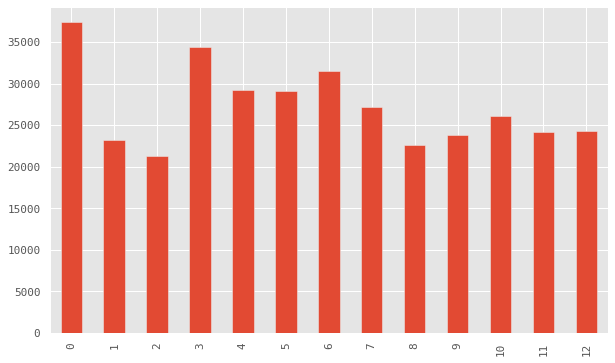

In [641]:
data['month'].value_counts().sort_index().plot(kind='bar')

## Reassign data varaible with relevant features

In [493]:
data = data[FEATURES]

## Cross correlations
TODO:
+ Explain the tests performed with `associations`.
+ Explain `stats.chi2_contingency()`.
+ add conclusions

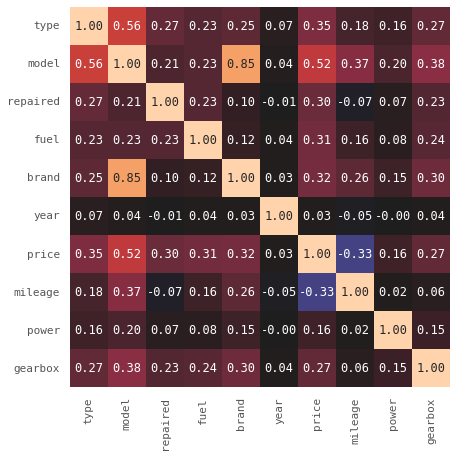

In [494]:
associations = associations(data,  cbar=False, figsize=(7, 7))

### Numerical features

In [495]:
data.corr()

,repaired,year,price,mileage,power
repaired,1.000000,0.021768,0.242167,-0.087478,0.031302
year,0.021768,1.000000,0.026916,-0.053447,-0.000828
price,0.242167,0.026916,1.000000,-0.333199,0.158872
mileage,-0.087478,-0.053447,-0.333199,1.000000,0.024002
power,0.031302,-0.000828,0.158872,0.024002,1.000000


In [496]:
# stats.chi2_contingency()
stats.chi2_contingency(
    pd.crosstab(
        data['brand'],
        data['model']
    )
)[1]


0.0

# Missing Values

## Utility function 

In [497]:
# this function help determining how unique is the relation between one feature 
#  (i.e. the grouped by feature) and another feature that is (preferably) correlated with it.
def get_top_value_ratio(group, feature):
    '''Return share of most common value's occurences in the group, from the total number of values in the group.'''
    most_common_value_count = group[feature].value_counts().nlargest(1)
    sum_of_value_counts = group['type'].value_counts().sum()
    return most_common_value_count / sum_of_value_counts


## Overview of missing values

In [498]:
data.isnull().sum()

type        37490
model       19705
repaired    71154
fuel        32895
brand           0
year            0
price           0
mileage         0
power           0
gearbox     19833
dtype: int64

In [499]:
data.isna().mean().round(4) * 100

type        10.58
model        5.56
repaired    20.08
fuel         9.28
brand        0.00
year         0.00
price        0.00
mileage      0.00
power        0.00
gearbox      5.60
dtype: float64

In [500]:
def sum_rows_with_any_nan(dataframe):
    sum_nans_in_row = dataframe.isnull().sum(axis=1)
    is_row_with_nan = sum_nans_in_row.apply(
        lambda value: True if value > 0 else False
    )
    sum_of_rows_with_nan = is_row_with_nan.sum()
    return sum_of_rows_with_nan

rows_with_nan = sum_rows_with_any_nan(data) 
print()
print(
    f"number of rows with any NaNs: "
    f"{rows_with_nan} "
    f"({rows_with_nan / len(data):.2%})"
)


number of rows with any NaNs: 108555 (30.63%)


## `model`

In [501]:
print()
print(
    f"Number of missing values: "
    f"{data.isnull().sum()['model']}"
    f"({(data.isna().mean().round(4))['model']:.2%})"
)


Number of missing values: 19705(5.56%)


### Group by price

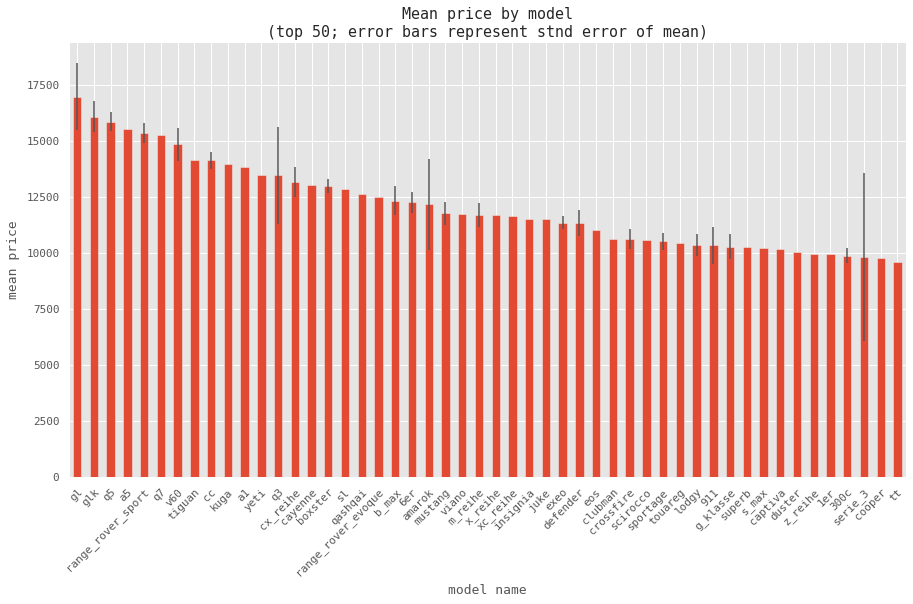

In [502]:
# group price by model
price_by_model = data.pivot_table(
    index='model',
    values='price',
    aggfunc=['mean', 'sem']
)
price_by_model.columns = ['mean', 'sem']

# plot mean price by model
plt.figure(figsize=(15, 8))
n_top = 50
barplot = (
    price_by_model['mean']
    .nlargest(n_top)
    .plot(
        kind='bar',
        yerr=price_by_model['sem'].nlargest(n_top)
    )
)
plt.xticks(ha='right', rotation_mode='anchor')
plt.tick_params(axis='x', labelrotation=45)
plt.ylabel('mean price')
plt.xlabel('model name')
plt.title(
    "Mean price by model\n"
    f"(top {n_top}; error bars represent stnd error of mean)"
);




* Price is not a good option to fill `model` missing values by. Car models could not be reasonably separated based on price.

### Group by brand

In [503]:
data.groupby(['brand']).apply(lambda group: group['model'].value_counts().nlargest(3)).head(20)

brand                
alfa_romeo  156            629
            147            572
            other          521
audi        a4            9900
            a3            6122
            a6            5541
bmw         3er          19761
            5er           7868
            1er           3514
chevrolet   other          950
            matiz          284
            captiva        168
chrysler    other          381
            voyager        342
            ptcruiser      308
citroen     other         1849
            berlingo       824
            c3             506
dacia       logan          322
            sandero        295
Name: model, dtype: int64

* `brand` may be a suitable feature to fill `model` missing values, by filling in the most common model for each brand.

### Fill missing values by brand

In [504]:
fill_nan_by_top_value = (
    lambda group:
    group.fillna(
        group.value_counts().index[0] # count value occurences in group and return the top most reccuring
        if any(group.value_counts().index) # condition that group has any values other than NaN
        else 'other' 
    )

)

data['model'] = data.groupby(['brand'])['model'].transform(fill_nan_by_top_value)

In [505]:
data['model'].isnull().sum()

0

## `type` 

In [506]:
data['type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: type, dtype: int64

In [507]:
data['type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [508]:
print()
print(
    f"Number of missing values: "
    f"{data.isnull().sum()['type']}"
    f"({(data.isna().mean().round(4))['type']:.2%})"
)


Number of missing values: 37490(10.58%)


### Group by model

In [509]:
# group data by models, 
#  count the appearnces of each type within each model group,
#  compute the ratio of the top type from all other values within the group

top_type_by_model = (
    data.groupby('model')
    .apply(get_top_value_ratio, 'type')
    .sort_values(ascending=False)
)

print(
    f"Share of top car type within each model group\n"
    f"-----------------------------------------\n"
    f"random sample:\n{top_type_by_model.sample(10)}\n\n"
    f"number of models where top type share is less than 50%: "
    f"{len(top_type_by_model.loc[top_type_by_model < 0.5])} "
    f"({len(top_type_by_model.loc[top_type_by_model < 0.5]) / len(top_type_by_model):.2%})"
)




Share of top car type within each model group
-----------------------------------------
random sample:
model                
forester  wagon          0.658333
touareg   suv            0.962898
v40       wagon          0.943878
scenic    bus            0.831981
vectra    sedan          0.568916
200       sedan          0.882353
z_reihe   convertible    0.927557
spider    convertible    0.988950
antara    suv            0.828283
b_max     bus            1.000000
Name: type, dtype: float64

number of models where top type share is less than 50%: 24 (9.60%)


* More than 90% of models are mostly associated with a single car type.
* Car type missing values can be filled according to car model.

### Fill missing values based on car model

In [510]:
# group by model and fill nan with top most common car type
data['type'] = data.groupby(['model'])['type'].transform(
    lambda group: group.fillna(group.value_counts().index[0])
) 


In [511]:
print(
    f"Missing values: {data['type'].isnull().sum()}\n\n"
    f"Value counts:\n{data['type'].value_counts()}"
)

Missing values: 0

Value counts:
sedan          109944
small           90344
wagon           69397
bus             31882
convertible     20458
coupe           16555
suv             12499
other            3290
Name: type, dtype: int64


## `fuel`

In [512]:
print(
    f"Missing values: {data['fuel'].isnull().sum()} "
    f"({data['fuel'].isnull().sum() / len(data['fuel']):.2%})"
)

Missing values: 32895 (9.28%)


In [513]:
data['fuel'].value_counts(normalize=True)

petrol      0.673000
gasoline    0.307085
lpg         0.016518
cng         0.001758
hybrid      0.000725
other       0.000635
electric    0.000280
Name: fuel, dtype: float64

* 'petrol' and 'gasoline' make up more than 90% of the values.

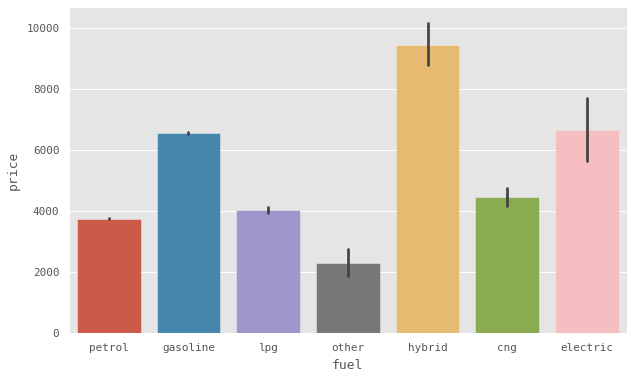

In [514]:
sns.barplot(data=data, x='fuel', y='price', estimator=np.mean);

* `fuel` type seems to have a notable effect on price.

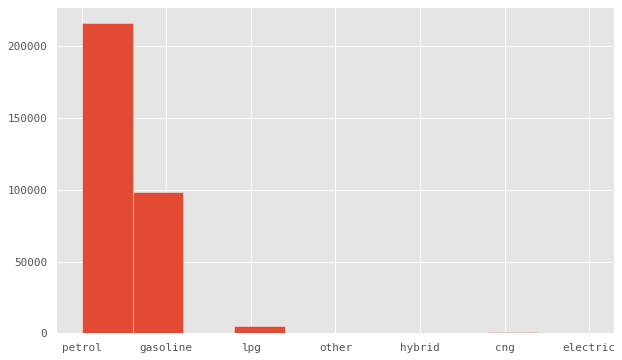

In [515]:
data['fuel'].hist();

In [516]:
data.groupby('model').apply(get_top_value_ratio, 'fuel').quantile(0.5)


0.7485177865612649

* Fuel type is for the most part highly associated with model.

### Fill missing values with most common fuel type

In [517]:
data['fuel'] = data['fuel'].fillna('petrol')

<AxesSubplot:>

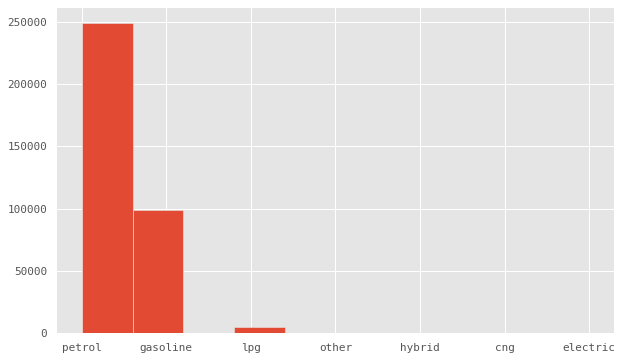

In [518]:
data['fuel'].hist()

## `gearbox`
TODO:
+ add a note about the output from `get_top_value_ratio`, it's not clear.

In [519]:
counts_before_fill = data['gearbox'].value_counts()
counts_before_fill

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [520]:

data.groupby('model').apply(get_top_value_ratio, 'gearbox').quantile(0.05)


0.5650317292437863

* More than 95% of model are mostly associated with a single gearbox type.
* We will therefore use car model to fill in missing gearbox values.

### Fill missing values based on model

In [521]:
# group by model and fill nan with the more common gearbox type for each particular model
data['gearbox'] = data.groupby(['model'])['gearbox'].transform(
    lambda group: group.fillna(group.value_counts().index[0])
) 


In [522]:
data['gearbox'].isnull().sum()

0

In [523]:
counts_after_fill = data['gearbox'].value_counts()
print()
print(
    f"value counts\n"
    f"------------\n"
    f"{counts_after_fill}\n\n"
    f"values added to each category\n"
    f"-----------------------------\n"
    f"{counts_after_fill - counts_before_fill}"
)


value counts
------------
manual    286286
auto       68083
Name: gearbox, dtype: int64

values added to each category
-----------------------------
manual    18035
auto       1798
Name: gearbox, dtype: int64


* All missing values were handled.
* Roughly 18 and 1.8k missing values were filled with 'manual' and 'auto' respectively 

## `repaired`

In [524]:
data['repaired'].value_counts()

1.0    247161
0.0     36054
Name: repaired, dtype: int64

In [525]:
data.groupby(pd.cut(data['mileage'], bins=10))['repaired'].mean()

mileage
(4855.0, 19500.0]       0.810459
(19500.0, 34000.0]      0.931154
(34000.0, 48500.0]      0.958080
(48500.0, 63000.0]      0.948523
(63000.0, 77500.0]      0.943143
(77500.0, 92000.0]      0.928507
(92000.0, 106500.0]     0.912605
(106500.0, 121000.0]         NaN
(121000.0, 135500.0]    0.905805
(135500.0, 150000.0]    0.847942
Name: repaired, dtype: float64

In [526]:
df =data[(1900 < data['year']) & (data['year']  < 2020)]
df.groupby(pd.cut(df['year'], bins=10))['repaired'].mean()

year
(1909.891, 1920.9]    0.400000
(1920.9, 1931.8]      0.700000
(1931.8, 1942.7]      0.695652
(1942.7, 1953.6]      0.888889
(1953.6, 1964.5]      0.843003
(1964.5, 1975.4]      0.871022
(1975.4, 1986.3]      0.851404
(1986.3, 1997.2]      0.795598
(1997.2, 2008.1]      0.873456
(2008.1, 2019.0]      0.923266
Name: repaired, dtype: float64

In [527]:
data.groupby('model')['repaired'].apply(lambda group: group.value_counts().nlargest(1))

model       
100      1.0     260
145      1.0      22
147      1.0     394
156      1.0     444
159      1.0     174
                ... 
yaris    1.0     902
yeti     1.0     164
ypsilon  1.0     145
z_reihe  1.0     653
zafira   1.0    2177
Name: repaired, Length: 249, dtype: int64

In [528]:
data.groupby('model').apply(get_top_value_ratio, 'repaired')

model       
100      1.0    0.623501
145      1.0    0.448980
147      1.0    0.688811
156      1.0    0.579634
159      1.0    0.820755
                  ...   
yaris    1.0    0.757983
yeti     1.0    0.942529
ypsilon  1.0    0.625000
z_reihe  1.0    0.910739
zafira   1.0    0.715177
Name: repaired, Length: 249, dtype: float64

In [529]:
data.groupby('model').apply(get_top_value_ratio, 'repaired').quantile(0.05)


0.5203593989092479

* More than 95% of model groups have a share of repaired cars higher than 50%.

### Fill missing values with most common value (1, i.e. repaired)

In [530]:
data['repaired'] = data['repaired'].fillna(1).astype('int')

## Final check for missing values

In [531]:
data.isnull().sum()

type        0
model       0
repaired    0
fuel        0
brand       0
year        0
price       0
mileage     0
power       0
gearbox     0
dtype: int64

* All missing values were handled.

# Remove the `brand` feature
* `brand` and `model` are highly correlated as seen by chi square test.
* `model` feature is also highly correlated with price.
* For these reasons we exclude the `brand` feature from model training.


In [532]:
data = data.drop('brand', axis=1)

# Outliers and unreasonable values

## Remove unreasonable registraion years from the `year` feature

In [533]:
data['year'].dtype

dtype('int64')

In [534]:
time_range = (1900, 2021)
observations_strange_dates = data[( data['year'] < time_range[0]) | (data['year'] > time_range[1])]
print(
    f"Observations with strange registration years: "
    f"{len(observations_strange_dates)}"
)

Observations with strange registration years: 171


In [535]:
data = data[(data['year'] > time_range[0]) & (data['year'] < time_range[1])]

In [536]:
data.year.describe()

count    354198.000000
mean       2003.084789
std           7.536418
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: year, dtype: float64

## Remove outliers in the `power` feature

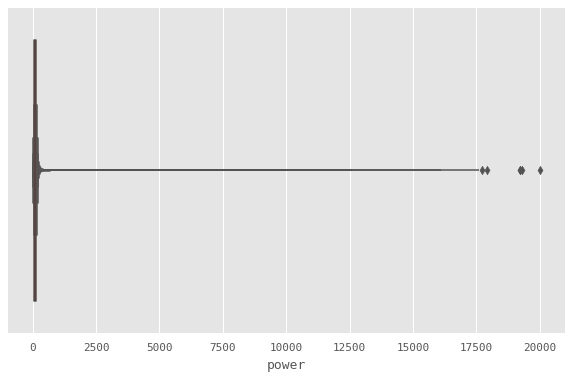

In [537]:
sns.boxenplot(x=data['power']);

In [546]:
quantile_limit = 0.999
quantile = data['power'].quantile(quantile_limit)
print(
    f"{1 - quantile_limit:.1%} of observations "
    f"with horse power above {quantile:.0f}"
)

0.1% of observations with horse power above 636


In [549]:
data = data[data['power'] < quantile]

In [550]:
data['power'].max()

620

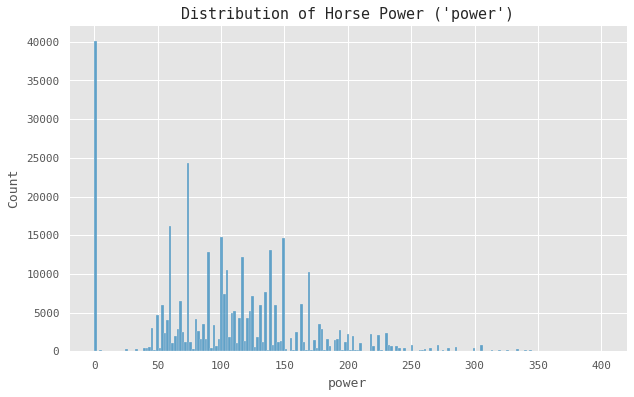

In [551]:
sns.histplot(binrange=(0, 400), x=data['power'])
plt.title("Distribution of Horse Power ('power')");

* ~40k observations with HP of **zero**

## Examine the distributions of observations with HP=0

In [575]:
power_is_zero = data[data['power'] == 0]


<Figure size 720x432 with 0 Axes>

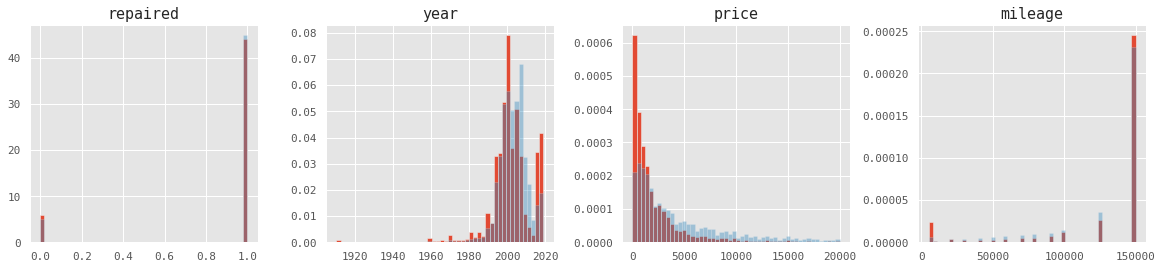

In [616]:
# plt.figure()
axes1 = power_is_zero.drop(columns='power').hist(bins=50, figsize=(20, 4), layout=(1, 4), density=True);
# axes2 = data.hist(bins=50);

for i, ax in enumerate(axes1.flatten()):
    feature = ax.get_title()
    if i < 5 :
        data[feature].hist(ax=ax, alpha=0.4, density=True, bins=50)   

* Distributions of observations with HP=0 is very similar to that of entire data set.

#### ax.get_title()

0
AxesSubplot(0.125,0.551739;0.215278x0.328261)


AssertionError: passed axis not bound to passed figure

<Figure size 720x432 with 0 Axes>

In [559]:
power_is_zero

,type,model,repaired,fuel,year,price,mileage,power,gearbox
0,sedan,golf,1,petrol,1993,480,150000,0,manual
15,small,ka,1,petrol,1910,450,5000,0,manual
32,sedan,golf,1,petrol,1994,245,150000,0,manual
37,bus,kangoo,1,gasoline,2016,1500,150000,0,manual
40,small,corsa,1,petrol,1990,0,150000,0,manual
...,...,...,...,...,...,...,...,...,...
354338,small,corsa,1,petrol,1995,180,125000,0,manual
354346,sedan,c_klasse,1,petrol,2005,2600,150000,0,auto
354363,bus,zafira,1,petrol,2000,1150,150000,0,manual
354364,sedan,colt,0,petrol,2005,0,150000,0,manual


## Check descriptive statistics 

In [390]:
data[NUMERICAL_FEATURES].describe()

,year,mileage,power
count,353899.000000,353899.000000,353899.000000
mean,2003.085654,128269.096550,106.650081
std,7.535476,37817.877341,64.176858
min,1910.000000,5000.000000,0.000000
25%,1999.000000,125000.000000,69.000000
50%,2003.000000,150000.000000,105.000000
75%,2008.000000,150000.000000,141.000000
max,2019.000000,150000.000000,999.000000


# Analysis

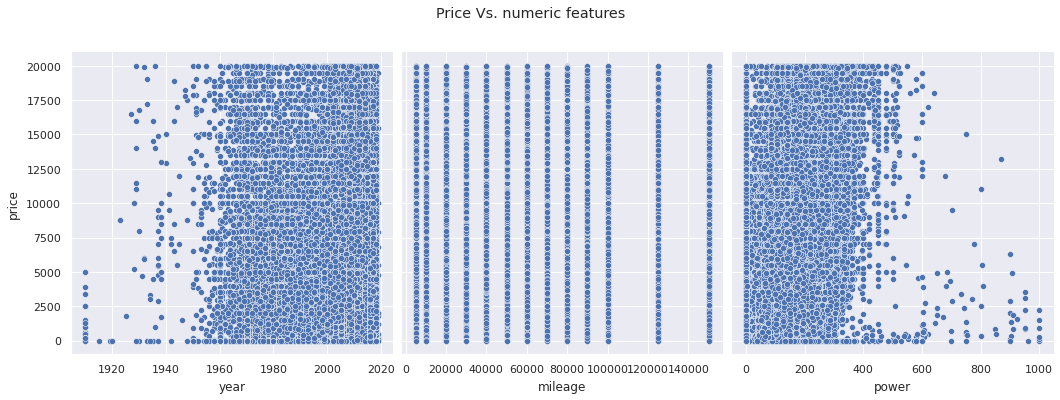

In [408]:
# data
g = sns.pairplot(
    data,
    x_vars=NUMERICAL_FEATURES,
    y_vars='price',
    height=5,
#     aspect=1.5
)
g.fig.suptitle(
    'Price Vs. numeric features',
    y=1.1
);


* We dont see any obvious correlations between the plotted features and the price variable.
* High HP cars seem to be associated with lower prices. This is somewhat unexpected, there's no obvious reason to assume high HP cars would be low priced.

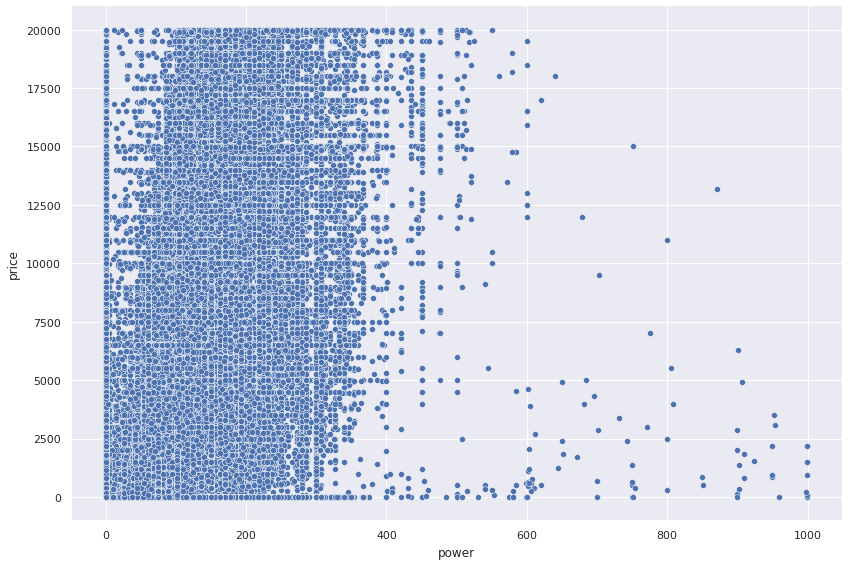

In [414]:
g = sns.pairplot(
    data,
    x_vars='power',
    y_vars='price',
#     size='year',
    height=8,
    aspect=1.5
)
# g.fig.suptitle(
#     'Price Vs. numeric features',
#     y=1.1
# );


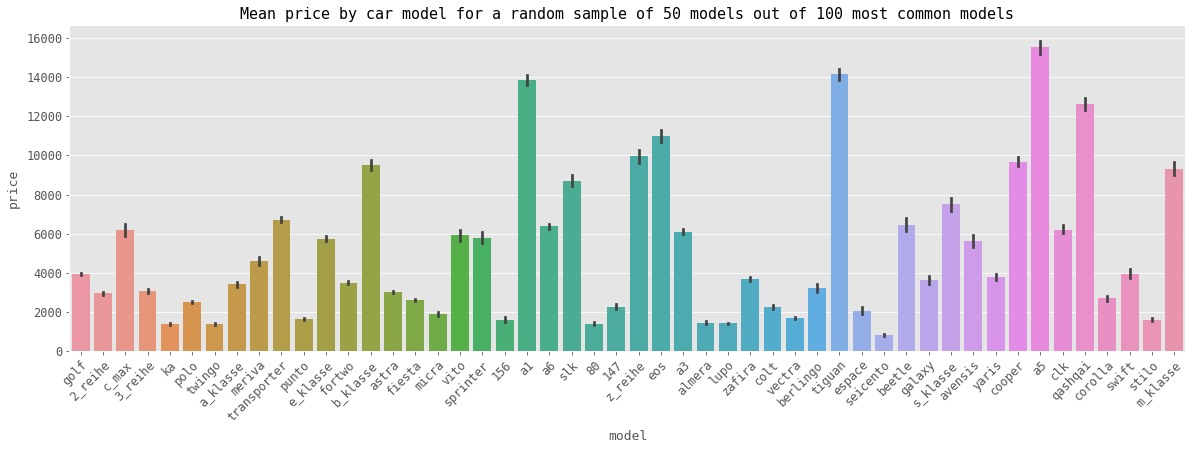

In [400]:
# sample n_models out of the 100 most common models
n_models = 50
sample_models = data['model'].value_counts().nlargest(100).sample(n_models).index
sample_models_data = data[data['model'].isin(sample_models)]

# plot mean price for each model
plt.figure(figsize=(20, 6))
ax = sns.barplot(x="model", y="price", data=sample_models_data)
plt.xticks(ha='right', rotation_mode='anchor')
plt.tick_params(axis='x', labelrotation=45)
title = (
    f"Mean price by car model for a random sample of {n_models} "
    "models out of 100 most common models"
)
plt.title(
    title,
    y=1
);

* car model seems like a good predictor of price.

# Modeling
TODO:
+ Use cross-validation for evaluation of different models.

## Utility functions

In [226]:
METRICS = [
    'rmse',
    'r_squared',
    'train_speed',
    'prediction_speed'
]

def evaluate_model(
        model_class,
        X_train, y_train,
        X_test, y_test):
    '''
    Train a model, print out and return evaluation metrices.
    
    Params
    ------
    model_class: a class implementing 'fit' and 'predict'
        An initialized model class instance.
    X_train: array like of shape (n_observations, n_features)
        train set features.
    y_train: array like of shape (n_observations,)
        train set target
    X_test: array like of shape (n_observations, n_features)
        test set features.
    y_test: array like of shape (n_observations,)
        test set target
   
    Returns
    -------
    results: dict
        Dictionary with quality and speed metrics.
        Keys are metric names and values are the obtained scores (or time).
    '''
    
    
     # train and record execution time
    train_time_t0 = time.time()
    model = model_class.fit(X_train, y_train) 
    train_time_t1 = time.time()
    train_speed = train_time_t1 - train_time_t0 

    # predict on test set and record execution time
    test_time_t0 = time.time()
    test_predictions = model.predict(X_test)
    test_time_t1 = time.time()
    test_speed = test_time_t1 - test_time_t0
    
    # prediction quality
    mse = metrics.mean_squared_error(
        test_predictions,
        y_test
    )
    rmse = mse**0.5
    r_squared = metrics.r2_score(
        test_predictions,
        y_test
    )
    
    # store results in dictionary
    metric_scores = [
        rmse,
        r_squared,
        train_speed,
        test_speed,
    ]
    results = {
        label: score
        for label, score
        in zip(METRICS, metric_scores)
    }
    return results
    
    

# Feature encoding
TODO:
+ Apply OrdinalEncoder to categorical features, and then use LightGBMs' built in encoder.

In [227]:
data.head()

,type,model,repaired,fuel,year,price,mileage,power,gearbox
0,sedan,golf,1,petrol,1993,480,150000,0,manual
1,coupe,a4,0,gasoline,2011,18300,125000,190,manual
2,suv,grand,1,gasoline,2004,9800,125000,163,auto
3,small,golf,1,petrol,2001,1500,150000,75,manual
4,small,fabia,1,gasoline,2008,3600,90000,69,manual


In [228]:
CATEGORICAL_FEATURS = ['model', 'fuel', 'type',]
BOOLEAN_FEATURES = ['gearbox', 'repaired']
NUMERICAL_FEATURES = ['year', 'mileage', 'power']

In [229]:
print(
    "Number of unique value in feature\n"
    "---------------------------------"
)
for feature in CATEGORICAL_FEATURS:
    print(
        f"{feature}: {data[feature].nunique()}"
    )

Number of unique value in feature
---------------------------------
model: 250
fuel: 7
type: 8


## Label encoding for `model`

In [230]:
label_encoder = preprocessing.LabelEncoder()
data['model'] = label_encoder.fit_transform(data['model'])

## OneHot encoding (OHE) for `fuel` and `type`


In [231]:
# categorical features
features_to_ohe = ['fuel', 'type', 'gearbox']

# encode
ohe = pd.get_dummies(data[features_to_ohe], drop_first=True)

In [232]:
# drop non encoded categorical features
dropped_categorical = data.drop(features_to_ohe, axis=1)

# concat OHE features to original data
data = pd.concat(
    [dropped_categorical, ohe],
    axis=1
)

In [233]:
data.head()

,model,repaired,year,price,mileage,power,fuel_electric,fuel_gasoline,fuel_hybrid,fuel_lpg,fuel_other,fuel_petrol,type_convertible,type_coupe,type_other,type_sedan,type_small,type_suv,type_wagon,gearbox_manual
0,116,1,1993,480,150000,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
1,29,0,2011,18300,125000,190,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,117,1,2004,9800,125000,163,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,116,1,2001,1500,150000,75,0,0,0,0,0,1,0,0,0,0,1,0,0,1
4,101,1,2008,3600,90000,69,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [234]:
data.columns

Index(['model', 'repaired', 'year', 'price', 'mileage', 'power',
       'fuel_electric', 'fuel_gasoline', 'fuel_hybrid', 'fuel_lpg',
       'fuel_other', 'fuel_petrol', 'type_convertible', 'type_coupe',
       'type_other', 'type_sedan', 'type_small', 'type_suv', 'type_wagon',
       'gearbox_manual'],
      dtype='object')

## Split the data

In [235]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('price', axis=1),
    data['price'],
    test_size=0.15,
)

In [236]:
print(
    "\nShape of features\n"
    "-----------------\n"
    f"Train set: {X_train.shape}\n"
    f"Test set: {X_test.shape}\n"
)


Shape of features
-----------------
Train set: (300814, 19)
Test set: (53085, 19)



## Dummy model

In [237]:
mean_price = y_train.mean()
dummy_predictions = [mean_price for i in y_test.index]

# evaluate
rmse = (
    metrics.mean_squared_error(y_test, dummy_predictions)**0.5
)
r_squared = metrics.r2_score(y_test, dummy_predictions)

print(
    f"RMSE: {rmse:.4f}\n"
    f"R-squared: {r_squared:.4f}\n"
)

RMSE: 4503.7866
R-squared: -0.0000



## Evaluate different base models using Cross-Validation

In [238]:
models = [
    LinearRegression(),
    RandomForestRegressor(),
    lightgbm.LGBMRegressor(),
]

In [239]:
metrics = 
for model in models:
    

SyntaxError: invalid syntax (<ipython-input-239-db1284fa0f0f>, line 1)

## Linear Regression

In [ ]:
lr_results = evaluate_model(
    LinearRegression(),
    X_train,
    y_train,
    X_test,
    y_test,
)

In [ ]:
pd.Series(lr_results)

## Random Forest

In [ ]:
rf_results = evaluate_model(
    RandomForestRegressor(),
    X_train,
    y_train,
    X_test,
    y_test,
)

In [ ]:
pd.Series(rf_results)

## LightGBM

### Basic setup

In [ ]:
lightgbm_results = evaluate_model(
    lightgbm.LGBMRegressor(random_state=12345),
    X_train,
    y_train,
    X_test,
    y_test,
)

In [ ]:
pd.Series(lightgbm_results)

### Grid Search Cross-Validation

In [ ]:
model = lightgbm.LGBMRegressor()
scoring = 'neg_root_mean_squared_error'
param_grid = {
    'n_estimators': [50, 150, 200],
    'max_depth': [5,10,20],
    'num_leaves': [25, 50, 100],
}

gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=5, 
        n_jobs=-1, 
        scoring=scoring,
        verbose=2
)

In [ ]:
start_time = time.time()
fitted_model = gs.fit(X_train, y_train)
end_time = time.time()

print()
print(
    f"Training time: {end_time - start_time}"
)

In [ ]:
lightgbm_cv = fitted_model.best_estimator_

## Compare models

In [ ]:
model_classes = [
    LinearRegression(),
    RandomForestRegressor(random_state=12345),
    lightgbm.LGBMRegressor(random_state=12345),
    lightgbm_cv
]
model_class_names = [
    'default-linear-regression',
    'default-random-forest',
    'defualt-lightbgm',
    'fine-tuned-lightgbm'
]

In [ ]:
results = pd.DataFrame(
    index=model_class_names,
    columns=METRICS
)
labels_models = tqdm(
    zip(
        model_class_names,
        model_classes
    ),
    total=4
)
for label, model_class in labels_models:
    model_results = evaluate_model(
        model_class,
        X_train,
        y_train,
        X_test,
        y_test
    )
    results.loc[label, METRICS] = [
        model_results[metric] 
        for metric 
        in METRICS
    ]

 
    



In [ ]:
results

## Visualize model prediction accuracy
TODO: find a better way to visualize (Residual plot?). See https://towardsdatascience.com/how-to-use-residual-plots-for-regression-model-validation-c3c70e8ab378.

In [ ]:
print()
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(x=data['price']);
error = results.loc['fine-tuned-lightgbm', 'rmse']
error_patch_width = error*2
error_patch_height = ax.get_ybound()[1]
patch_position = (
    ax.get_xbound()[1]/2 - error_patch_width/1.5 ,
    0,#ax.get_ybound()[1] - ax.get_ybound()[1]/3
)
rectangle = Rectangle(
    patch_position,
    error_patch_width,
    error_patch_height,
    facecolor='orange',
    alpha=0.2
)
rx, ry = rectangle.get_xy()
cx = rx + rectangle.get_width()/2.0
cy = ry + rectangle.get_height()/2.0
rectangle_center = Line2D(
    (cx, cx),
    (cy-error_patch_height, cy+error_patch_height),
    lw=0.5,
    color='k'
)

ax.add_patch(rectangle)
ax.add_line(rectangle_center)
ax.legend(((rectangle),), ('prediction error margin',))

plt.title(
    f"Histogram of historical car sale prices, with final LightGBM prediction error margin",
    y=1.05,
    size=15
);

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
I'm not sure what this plot represents. Is the yellow strip mean predicted price +- standard deviation? I don't understand what it illustrates being plotted over the histogram of prices though. Maybe something like a [residual plot](https://towardsdatascience.com/how-to-use-residual-plots-for-regression-model-validation-c3c70e8ab378) would be more informative
	  
</div>

# Summary and conclusions
+ The goal of this project was to build a model that will predict a car's price based on it's specifications.
+ The provided data contained historical records of car sale prices along with various details of the sold cars.

## Pre-processing
+ Irrelevant features were removed (e.g. date of sale).
+ Missing values were eliminated using appropraite cross correlations between the features.
+ Categorical features were encoded based on number of categories within the feature.
+ Observations with extreme and unreasonable values were removed (e.g. registration year higher than 2021).

## Modeling
+ Data was split into train and test sets.
+ Three different regression models were trained and evaluated using test set, taking both model quality and speed into account.
+ A lightGBM regression model was fine tuned using GridSearch Cross-Validation.

## Final conclusions
+ Linear Regression model was roughly an order of magnitutde faster in both training and prediction speed, when compared with the ensemble based models.
+ Ensemble based models provided far better predictions than the basic Linear Regression model.
+ Random Forest (RF) model was comparable to the LightGBM (LGMB) model in terms of prediction quality, with fine tuned LGBM outperforming the RF model in terms of speed by an order of magnitutde or more, and also producing a slightly better prediction.
+ The fine tuned LGBM model presented the best overall performace.
